In [60]:
import json

# Load data from the JSON file
with open('51n.json', 'r') as f:
    data = json.load(f)

# Extract main bounding box
main_box_data = data['boundingBox']
main_box = [
    main_box_data['sw']['latitude'],
    main_box_data['sw']['longitude'],
    main_box_data['ne']['latitude'],
    main_box_data['ne']['longitude']
]

# Extract solar panel data
solarPotential_data = data['solarPotential']
solar_panels_data = solarPotential_data.get('solarPanels', [])
solarPotential_structure = {key: type(value).__name__ for key, value in solarPotential_data.items()}

# Print the number of solar panels
#print(f"Number of solar panels: {len(solar_panels_data)}")

# Extract roof segment statistics
roofSegmentStats_data = solarPotential_data.get('roofSegmentStats', [])

bounding_box_data = data['boundingBox']

# Extract heights of each sample and store in a list
sample_heights = []
for i, segment in enumerate(roofSegmentStats_data):
    height = segment.get('planeHeightAtCenterMeters', None)
    if height is not None:
        sample_heights.append(height)

# Extract sample boxes
sample_boxes = []
for sample in roofSegmentStats_data:
    box = sample.get('boundingBox', {})
    sw = box.get('sw', {})
    ne = box.get('ne', {})
    sample_box = [
        sw.get('latitude', None),
        sw.get('longitude', None),
        ne.get('latitude', None),
        ne.get('longitude', None)
    ]
    sample_boxes.append(sample_box)

# Dimensions of a single solar panel in inches
panel_width = 60
panel_height = 70



In [2]:
from scipy.optimize import minimize_scalar
import math
import pandas as pd
import folium
import logging

logging.basicConfig(level=logging.INFO)

# Function to rotate a point
def rotate_point(x, y, angle_degrees, cx, cy):
    angle_radians = math.radians(angle_degrees)
    dx = x - cx
    dy = y - cy
    rotated_dx = dx * math.cos(angle_radians) - dy * math.sin(angle_radians)
    rotated_dy = dx * math.sin(angle_radians) + dy * math.cos(angle_radians)
    return cx + rotated_dx, cy + rotated_dy

# Function to calculate rotated bounding box area
def rotated_area(angle_degrees, original_area, aspect_ratio):
    angle_radians = math.radians(float(angle_degrees))
    return original_area * (math.cos(angle_radians) + aspect_ratio * math.sin(angle_radians))

# Function to find the optimal rotation angle
def find_common_optimal_rotation_angle(data):
    def objective(angle_degrees):
        total_diff = 0
        for segment in data['solarPotential']['roofSegmentStats']:
            sw = segment['boundingBox']['sw']
            ne = segment['boundingBox']['ne']
            original_area = abs((ne['latitude'] - sw['latitude']) * (ne['longitude'] - sw['longitude']))
            aspect_ratio = abs((ne['longitude'] - sw['longitude']) / (ne['latitude'] - sw['latitude']))
            target_area = segment['stats']['groundAreaMeters2']
            diff = abs(rotated_area(angle_degrees, original_area, aspect_ratio) - target_area)
            
            # Weighted by the original area
            weighted_diff = diff * original_area
            
            total_diff += weighted_diff
        return total_diff
    
    result = minimize_scalar(objective, bounds=(0, 90), method='bounded', options={'maxiter': 100})
    return result.x

# Find the common optimal angle for all segments
common_optimal_angle = find_common_optimal_rotation_angle(data)
logging.info(f"Common optimal angle for all segments: {common_optimal_angle}")

# Initialize the folium map centered around a sample location
first_sample = data['solarPotential']['roofSegmentStats'][0]
initial_ne = first_sample['boundingBox']['ne']
initial_location = [initial_ne['latitude'], initial_ne['longitude']]
m = folium.Map(location=initial_location, zoom_start=15)

# Loop through each segment in 'roofSegmentStats'
for i, segment in enumerate(data['solarPotential']['roofSegmentStats']):
    center = segment['center']
    center_lat, center_long = center['latitude'], center['longitude']
    
    sw = segment['boundingBox']['sw']
    ne = segment['boundingBox']['ne']
    width = abs(ne['longitude'] - sw['longitude'])
    height = abs(ne['latitude'] - sw['latitude'])
    
    # Rotate the corners around the center
    rotated_sw = rotate_point(sw['latitude'], sw['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_ne = rotate_point(ne['latitude'], ne['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_se = rotate_point(ne['latitude'], sw['longitude'], common_optimal_angle, center_lat, center_long)
    rotated_nw = rotate_point(sw['latitude'], ne['longitude'], common_optimal_angle, center_lat, center_long)
    
    # Draw the rotated bounding box as a polygon on the map
    folium.Polygon([rotated_sw, rotated_se, rotated_ne, rotated_nw, rotated_sw], color='red').add_to(m)
    #logging.info(f"Added bounding box with corners: {rotated_sw, rotated_se, rotated_ne, rotated_nw}")

# Show the map
m


INFO:root:Common optimal angle for all segments: 62.11802161326996


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import symbols, solve, Eq, sqrt
# Given points A(x1, y1) and B(x2, y2) and area A
x1, y1 = 0, 0
A = (x1, y1)
x2, y2 = 4, 3
B = (x2, y2)
Area = 15

# Calculate distance d between A and B
d = sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Calculate radius r of the circumcircle
r = d / 2

# Calculate the center O of the circumcircle
x_center = (x1 + x2) / 2
y_center = (y1 + y2) / 2

# Calculate the other dimension (either width or height) using the area A
other_dimension = Area / d

# Use the equation of the circle to find point C(x3, y3)
x3, y3 = symbols('x3 y3')

# Equation of the circle
eq1 = Eq((x3 - x_center)**2 + (y3 - y_center)**2, r**2)

# Equation representing the distance from A to C equal to the other dimension
eq2 = Eq(sqrt((x3 - x1)**2 + (y3 - y1)**2), other_dimension)

# Equation for 90-degree angles using dot product of vectors AB and AC
eq3 = Eq((x3 - x1) * (x2 - x3) + (y3 - y1) * (y2 - y3), 0)

# Solve the equations to find point C(x3, y3)
solution_with_dot_product = solve((eq1, eq2, eq3), (x3, y3))
C1,C2 = solution_with_dot_product
final_c= [C1,C2]
print (C1,C2)

# Function to calculate D1 and D2 algebraically without using the solve function
def calculate_D_algebraic(x_center, y_center, C):
    x3, y3 = C
    x4 = 2 * x_center - x3
    y4 = 2 * y_center - y3
    return x4, y4

# Initialize list to store the corresponding D points using the algebraic method
D_points_algebraic = []

# Calculate D for each C using the algebraic method
for C in final_c:
    D = calculate_D_algebraic(x_center, y_center, C)
    D_points_algebraic.append(D)

D1,D2 = D_points_algebraic

(0.0, 3.00000000000000) (2.88000000000000, -0.840000000000000)


In [40]:
import sympy as sp
import math
import numpy as np
from sympy import symbols, solve, Eq, sqrt
# Average latitude for North America (example: 40 degrees North)
average_latitude = 35

# Constants for distance calculations
METERS_PER_DEGREE_LAT = 111000  # Approximate meters per degree of latitude
METERS_PER_DEGREE_LON = METERS_PER_DEGREE_LAT * math.cos(math.radians(average_latitude))

#Sample 1: SW = (42.271187999999995, -71.0849068), NE = (42.271236699999996, -71.0848022)
# Given points A(x1, y1) and B(x2, y2) and area A
lat1, lon1 = (42.271187999999995, -71.0849068)
A = (lat1, lon1)
lat2, lon2 = (42.271236699999996, -71.0848022)
B = (lat2, lon2)
Area = 20

# Calculate the center O of the circumcircle
x_center = (lat1 + lat2) / 2
y_center = (lon1 + lon2) / 2
# Calculate distance d between A and B
distance_lat = (lat2 - lat1) * METERS_PER_DEGREE_LAT
distance_lon = (lon2 - lon1) * METERS_PER_DEGREE_LON

# Calculate the actual distance d between A and B using Pythagoras theorem
d = sp.sqrt(distance_lat**2 + distance_lon**2)

# Define the symbols for width (w) and height (h)
w, h = sp.symbols('w h', real=True)

# Equation for the area and diagonal of the rectangle
eq_area = sp.Eq(w * h, Area)
eq_diag = sp.Eq(w**2 + h**2, d**2)

# Solve the system of equations
solutions = sp.solve((eq_area, eq_diag), (w, h))

# Check if there are any solutions
if solutions:
    # Take the solution with the positive width and height
    width, height = next((sol for sol in solutions if sol[0] > 0 and sol[1] > 0), (None, None))

    # Define symbols for point C (x3, y3)
    lat3, lon3 = sp.symbols('lat3 lon3', real=True)

    # Equations based on the rectangle's sides and Pythagorean theorem
    eq1 = Eq ((lat3 - lat1)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon1)**2 * METERS_PER_DEGREE_LON**2, height**2)
    eq2 = Eq ((lat3 - lat2)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon2)**2 * METERS_PER_DEGREE_LON**2, width**2)
    # Equation for 90-degree angles using dot product of vectors AB and AC
    #eq3 = Eq ((lat3 - lat1) * (lat3 - lat2)* METERS_PER_DEGREE_LAT**2 + (lon3 - lon1) * (lon3 - lon2)* METERS_PER_DEGREE_LON**2, 0)

    # Solve the equations to find point C
    solution_for_C = sp.solve((eq1, eq2,eq3), (x3, y3))

    # There may be two valid solutions for point C
    if solution_for_C:
        C1, C2 = solution_for_C[0], solution_for_C[1]

        # Function to calculate D algebraically without using the solve function
        def calculate_D_algebraic(C):
            lat3, lon3 = C
            lat4 = (2 * x_center - lat3) 
            lon4 = (2 * y_center - lon3)
            return lat4, lon4
        # Calculate D for each C using the algebraic method
        D1 = calculate_D_algebraic(C1)
        D2 = calculate_D_algebraic(C2)
    else:
        C1, C2, D1, D2 = (None, None), (None, None), (None, None), (None, None)
else:
    width, height, C1, C2, D1, D2 = (None,) * 6

print(C1,C2,D1,D2)


(42.2711749272716, -71.0848913669754) (42.2712045142647, -71.0849148411415) (42.2712497727284, -71.0848176330246) (42.2712201857353, -71.0847941588585)


In [112]:
import sympy as sp

def find_rectangle_vertices(NE, SW, Area):
    # Average latitude for North America (example: 40 degrees North)
    average_latitude = 35

    # Constants for distance calculations
    METERS_PER_DEGREE_LAT = 111000  # Approximate meters per degree of latitude
    METERS_PER_DEGREE_LON = METERS_PER_DEGREE_LAT * math.cos(math.radians(average_latitude))

    # Extract latitude and longitude from NE and SW
    lat1, lon1 = SW
    lat2, lon2 = NE

    # Calculate the center of the line AB
    lat_center = (lat1 + lat2) / 2
    lon_center = (lon1 + lon2) / 2

    # Calculate the distances between the latitudes and longitudes
    distance_lat = (lat2 - lat1) * METERS_PER_DEGREE_LAT
    distance_lon = (lon2 - lon1) * METERS_PER_DEGREE_LON

    # Calculate the actual distance d between A and B using the Pythagorean theorem
    d = sp.sqrt(distance_lat**2 + distance_lon**2)

    # Define the symbols for width (w) and height (h)
    w, h = sp.symbols('w h', real=True)

    # Equation for the area and diagonal of the rectangle
    eq_area = sp.Eq(w * h, Area)
    eq_diag = sp.Eq(w**2 + h**2, d**2)

    # Solve the system of equations
    solutions = sp.solve((eq_area, eq_diag), (w, h))

    # Initialize an empty list to store the rectangle vertices
    rectangles = []

    # Check if there are any solutions
    if solutions:
        # Take the solution with the positive width and height
        width, height = next((sol for sol in solutions if sol[0] > 0 and sol[1] > 0), (None, None))

        # Define symbols for point C (x3, y3)
        lat3, lon3 = sp.symbols('lat3 lon3', real=True)

         # Equations based on the rectangle's sides and Pythagorean theorem
        eq1 = Eq ((lat3 - lat1)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon1)**2 * METERS_PER_DEGREE_LON**2, height**2)
        eq2 = Eq ((lat3 - lat2)**2 * METERS_PER_DEGREE_LAT**2 + (lon3 - lon2)**2 * METERS_PER_DEGREE_LON**2, width**2)
        # Equation for 90-degree angles using dot product of vectors AB and AC
        #eq3 = Eq ((lat3 - lat1) * (lat3 - lat2)* METERS_PER_DEGREE_LAT**2 + (lon3 - lon1) * (lon3 - lon2)* METERS_PER_DEGREE_LON**2, 0)

        # Solve the equations to find point C
        solution_for_C = sp.solve((eq1, eq2,eq3), (lat3, lon3))

        # Calculate points C and D for each solution
        for C in solution_for_C:
            lat3, lon3 = C
            lat4 = 2 * lat_center - lat3
            lon4 = 2 * lon_center - lon3
            D = (lat4, lon4)
            rectangles.append(((lat1, lon1), (lat2, lon2), C, D))

    return rectangles

# Example usage
NE = (42.271236699999996, -71.0848022)
SW = (42.271187999999995, -71.0849068)
Area = 20

results = find_rectangle_vertices(NE, SW, Area)
results[0]

((42.271187999999995, -71.0849068),
 (42.271236699999996, -71.0848022),
 (42.2711750813400, -71.0848938569970),
 (42.2712496186600, -71.0848151430030))

In [104]:
# Extract the southwest and northeast points
sw_lat = data['boundingBox']['sw']['latitude']
sw_lon = data['boundingBox']['sw']['longitude']
ne_lat = data['boundingBox']['ne']['latitude']
ne_lon = data['boundingBox']['ne']['longitude']

# Extract the area from the solarPotential
area = data['solarPotential']['wholeRoofStats']['areaMeters2']

# Convert these points into a format suitable for your function
# Assuming find_rectangle_vertices accepts southwest and northeast points as tuples and the area as a float
sw_point = (sw_lat, sw_lon)
ne_point = (ne_lat, ne_lon)

# Now you can call your find_rectangle_vertices function
# Here's a placeholder for how the call might look, but it depends on the actual signature of your function
vertices = find_rectangle_vertices(SW=sw_point, NE=ne_point, Area=area)

# Print the results or process them as needed 

[((42.271184399999996, -71.08495789999999), (42.2713159, -71.0848022), (42.2711624447939, -71.0848979192382), (42.2713378552061, -71.0848621807618)), ((42.271184399999996, -71.08495789999999), (42.2713159, -71.0848022), (42.2712279941393, -71.0849922596064), (42.2712723058607, -71.0847678403936))]


In [117]:
sample_heights

[16.634693, 16.832132, 16.988735, 16.505928, 10.415322, 16.681196]

In [119]:
import pandas as pd

# Create a list to hold dictionaries for each row
data_rows = []

# Loop through each sample in the JSON data
for sample in roofSegmentStats_data:
    # Extract the bounding box and the area from the sample
    SW_lat = sample['boundingBox']['sw']['latitude']
    SW_lon = sample['boundingBox']['sw']['longitude']
    NE_lat = sample['boundingBox']['ne']['latitude']
    NE_lon = sample['boundingBox']['ne']['longitude']
    Area = sample['stats']['groundAreaMeters2']
    sample_height = sample['planeHeightAtCenterMeters']
    
    # Convert SW and NE to tuples
    SW = (SW_lat, SW_lon)
    NE = (NE_lat, NE_lon)
    
    # Calculate the rectangle vertices using the function
    rectangle_vertices = find_rectangle_vertices(NE, SW, Area)
    
    # Check if two results are found and append them to the list with labels
    if rectangle_vertices and len(rectangle_vertices) == 2:
        data_rows.append({
            'Label': '1',
            'A': rectangle_vertices[0][0],
            'B': rectangle_vertices[0][1],
            'C': rectangle_vertices[0][2],
            'D': rectangle_vertices[0][3],
            'Sampleheight': sample_height
        })
        data_rows.append({
            'Label': '2',
            'A': rectangle_vertices[1][0],
            'B': rectangle_vertices[1][1],
            'C': rectangle_vertices[1][2],
            'D': rectangle_vertices[1][3],
            'Sampleheight': sample_height
        })

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data_rows)

# Display the DataFrame
print(df_results)



   Label                                         A  \
0      1         (42.271187999999995, -71.0849068)   
1      2         (42.271187999999995, -71.0849068)   
2      1         (42.271228099999995, -71.0849289)   
3      2         (42.271228099999995, -71.0849289)   
4      1  (42.271233699999996, -71.08487250000002)   
5      2  (42.271233699999996, -71.08487250000002)   
6      1                 (42.2712703, -71.0849361)   
7      2                 (42.2712703, -71.0849361)   
8      1                  (42.2711889, -71.084957)   
9      2                  (42.2711889, -71.084957)   
10     1          (42.2712104, -71.08491529999999)   
11     2          (42.2712104, -71.08491529999999)   

                                    B                                      C  \
0   (42.271236699999996, -71.0848022)  (42.2711731803469, -71.0848910023426)   
1   (42.271236699999996, -71.0848022)  (42.2712067011198, -71.0849142608726)   
2    (42.2712808, -71.08485449999999)  (42.2712162269834,

In [120]:
# split into lable equal to 1 and label equal to 2
df_results_1 = df_results[df_results['Label'] == '1']
df_results_2 = df_results[df_results['Label'] == '2']

df_results_1.head()

,Label,A,B,C,D,Sampleheight
0,1,"(42.271187999999995, -71.0849068)","(42.271236699999996, -71.0848022)","(42.2711731803469, -71.0848910023426)","(42.2712515196531, -71.0848179976574)",16.634693
2,1,"(42.271228099999995, -71.0849289)","(42.2712808, -71.08485449999999)","(42.2712162269834, -71.0849072328427)","(42.2712926730166, -71.0848761671573)",16.832132
4,1,"(42.271233699999996, -71.08487250000002)","(42.2712994, -71.0848183)","(42.2712270864742, -71.0848500564415)","(42.2713060135258, -71.0848407435585)",16.988735
6,1,"(42.2712703, -71.0849361)","(42.271315099999995, -71.0848474)","(42.2712574526824, -71.0849211301514)","(42.2713279473176, -71.0848623698486)",16.505928
8,1,"(42.2711889, -71.084957)","(42.2712888, -71.0849053)","(42.2711866978064, -71.0849494019169)","(42.2712910021936, -71.0849128980831)",10.415322


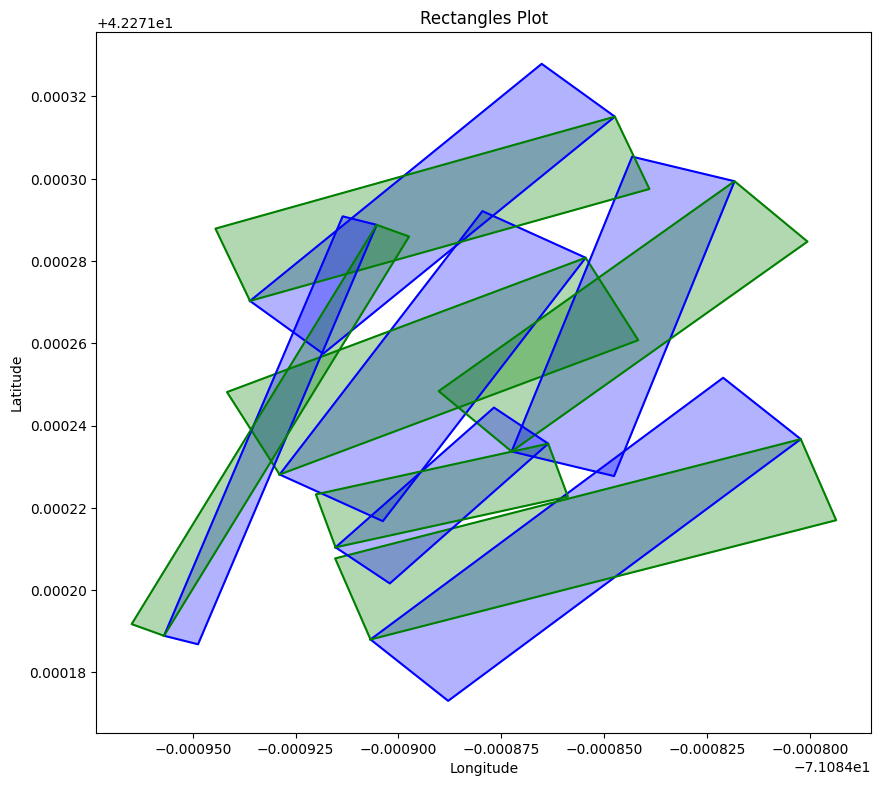

In [121]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_rectangles(df):
    # Create a new figure and axis for the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define colors for each label
    color_map = {1: 'blue', 2: 'green'}
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        # Extract points A, B, C, D and label
        A = row['A']
        B = row['B']
        C = row['C']
        D = row['D']
        label = row['Label']
        
        # Extract the x and y coordinates
        x_coords = [A[1], C[1], B[1], D[1], A[1]]
        y_coords = [A[0], C[0], B[0], D[0], A[0]]
        
        # Draw the rectangle
        ax.plot(x_coords, y_coords, color=color_map[int(label)])
        
        # Add a patch to the plot with a semi-transparent fill
        rect = patches.Polygon(xy=list(zip(x_coords, y_coords)), closed=True, fill=True, color=color_map[int(label)], alpha=0.3)
        ax.add_patch(rect)
    
    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')
    
    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Rectangles Plot')
    
    # Show the plot
    plt.show()

# Assuming 'df' is the DataFrame containing your data
draw_rectangles(df)


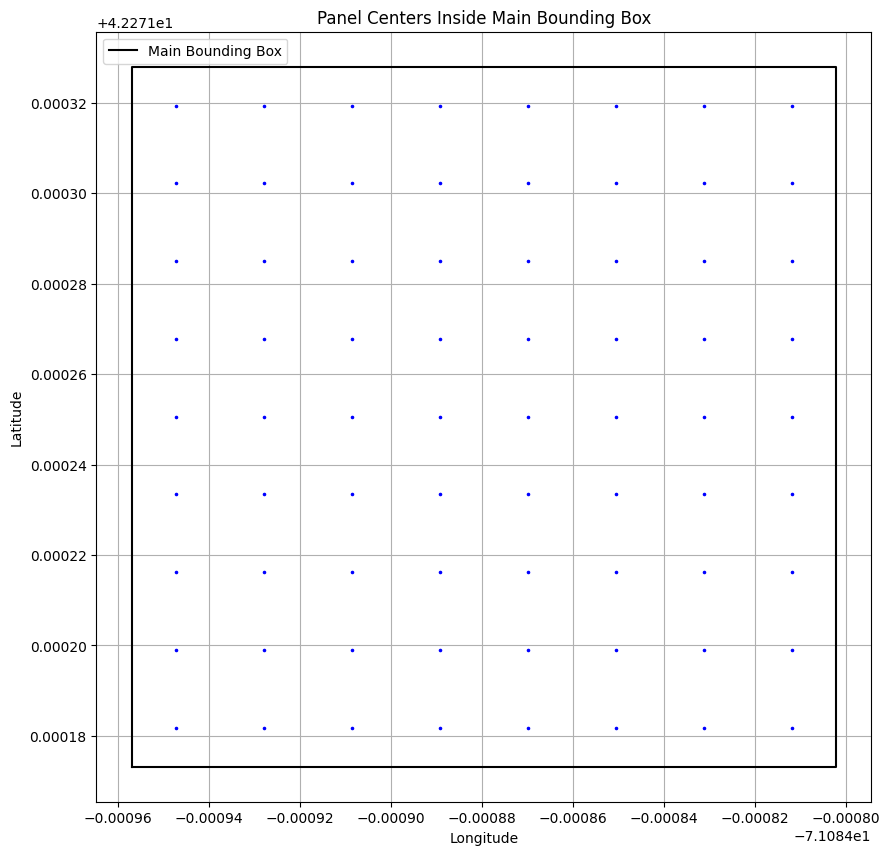

Total number of panels that can fit inside the main bounding box: 72


In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import radians, sin, cos, sqrt, atan2
def find_smallest_bounding_box(df):
    # Extract all latitudes and longitudes from the DataFrame
    all_lats = []
    all_lons = []
    for column in ['A', 'B', 'C', 'D']:
        all_lats.extend(df[column].apply(lambda x: x[0]))
        all_lons.extend(df[column].apply(lambda x: x[1]))

    # Find the min and max of latitudes and longitudes
    min_lat = min(all_lats)
    max_lat = max(all_lats)
    min_lon = min(all_lons)
    max_lon = max(all_lons)

    # SW and NE corners
    sw_corner = (min_lat, min_lon)
    ne_corner = (max_lat, max_lon)

    return sw_corner, ne_corner

box = find_smallest_bounding_box(df_results_1)

# Extract main bounding box
main_box = [
    box[0][0],
    box[0][1],
    box[1][0],
    box[1][1]
]
    

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Function to calculate the Haversine distance between two points on the Earth's surface
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c  # Distance in miles
    return distance * 63360  # Convert to inches

# Function to calculate the number of panels that can fit inside a bounding box
def panels_in_bounding_box(bounding_box, panel_width, panel_height):
    sw_lat, sw_lon, ne_lat, ne_lon = bounding_box

    # Calculate the width and height of the bounding box in inches using Haversine formula
    width = haversine_distance(sw_lat, sw_lon, sw_lat, ne_lon)
    height = haversine_distance(sw_lat, sw_lon, ne_lat, sw_lon)

    # Calculate the number of panels that can fit
    panels_in_width = int(width // panel_width)
    panels_in_height = int(height // panel_height)
    total_panels = panels_in_width * panels_in_height

    return total_panels

# Function to calculate the panel centers
def calculate_panel_centers(bounding_box, panel_width, panel_height):
    sw_lat, sw_lon, ne_lat, ne_lon = bounding_box

    # Calculate the number of panels in width and height
    panels_in_width = int(haversine_distance(sw_lat, sw_lon, sw_lat, ne_lon) // panel_width)
    panels_in_height = int(haversine_distance(sw_lat, sw_lon, ne_lat, sw_lon) // panel_height)

    # Calculate the step size for panel centers
    lat_step = (ne_lat - sw_lat) / panels_in_height
    lon_step = (ne_lon - sw_lon) / panels_in_width

    # Calculate and store panel centers along with their latitudes and longitudes
    panel_centers = []
    for i in range(panels_in_height):
        for j in range(panels_in_width):
            center_lat = sw_lat + i * lat_step + lat_step / 2
            center_lon = sw_lon + j * lon_step + lon_step / 2
            panel_centers.append((center_lat, center_lon))
            #print(f"Panel Center {len(panel_centers)} - Latitude: {center_lat}, Longitude: {center_lon}")

    return panel_centers



# Calculate the number of panels that can fit inside the main bounding box
total_panels_in_main_box = panels_in_bounding_box(main_box, panel_width, panel_height)

# Calculate panel centers and print their latitudes and longitudes
panel_centers = calculate_panel_centers(main_box, panel_width, panel_height)

# Plotting code
plt.figure(figsize=(10, 10))
plt.plot([main_box[1], main_box[3], main_box[3], main_box[1], main_box[1]], 
         [main_box[0], main_box[0], main_box[2], main_box[2], main_box[0]], 'k-', label='Main Bounding Box')

# Plot panel centers
for center in panel_centers:
    plt.scatter(center[1], center[0], c='b', marker='.', s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Panel Centers Inside Main Bounding Box')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
# Print the result
print("Total number of panels that can fit inside the main bounding box:", total_panels_in_main_box)

In [123]:
from math import radians, sin, cos, sqrt, atan2

# Function to calculate the Haversine distance between two points on the Earth's surface
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c  # Distance in miles
    return distance * 63360  # Convert to inches

# Function to calculate distances between neighboring panel centers
def calculate_distances(panel_centers):
    num_centers = len(panel_centers)
    min_distances = {}

    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            lat1, lon1 = panel_centers[i]
            lat2, lon2 = panel_centers[j]
            distance = haversine_distance(lat1, lon1, lat2, lon2)
            min_distances[(i, j)] = distance

    return min_distances


# Calculate minimum distances between neighboring panel centers in inches
distances = calculate_distances(panel_centers)

# Find the minimum distance
min_distance = min(distances.values())

# Print the minimum distance in inches
print(f"Minimum distance between neighboring panels: {min_distance} inches")

Minimum distance between neighboring panels: 62.68302449734502 inches


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Declare panel_df as global
global panel_df

def assign_panel_numbers_and_colors(panel_centers, sample_bounding_boxes, sample_heights):
    global panel_df  # Indicate that we are using the global variable
    panel_info = []
    panel_numbers = {}
    panel_colors = {}
    
    for i, panel_center in enumerate(panel_centers):
        #print(f"Checking panel at {panel_center}")
        lat, lon = panel_center
        assigned_sample = None
        highest_sample_height = -1

        for j, (sample_name, bounding_box) in enumerate(sample_bounding_boxes.items()):
            #=print(f"Panel at {lat}, {lon} is being checked against {sample_name}")
            sw_lat, sw_lon, ne_lat, ne_lon = bounding_box
            #print(f"sw_lat: {sw_lat}, sw_lon: {sw_lon}, ne_lat: {ne_lat}, ne_lon: {ne_lon}, lat: {lat}, lon: {lon}")
            if sw_lat <= lat <= ne_lat and sw_lon <= lon <= ne_lon:
                print(f"Panel at {lat}, {lon} is within bounding box {bounding_box}")
                if sample_heights[j] > highest_sample_height:
                    print(f"Panel at {lat}, {lon} is assigned to {sample_name}")
                    assigned_sample = sample_name
                    if sample_heights[j] > highest_sample_height:
                        print(f"the highest changed from {highest_sample_height} to {sample_heights[j]}")
                    highest_sample_height = sample_heights[j]

        if assigned_sample:
            #print( f"Panel at {lat}, {lon} is assigned to {assigned_sample}")
            panel_number = len(panel_numbers) + 1
            panel_numbers[panel_center] = panel_number
            panel_colors[panel_center] = cm.tab20(i)
            panel_info.append([panel_number, assigned_sample, panel_center, highest_sample_height])
            
    panel_df = pd.DataFrame(panel_info, columns=['Panel Number', 'Sample Assigned', 'Panel Center', 'Panel Height'])
    
    # Filter out unassigned panels
    panel_df = panel_df[panel_df['Sample Assigned'].notna()]
    
    return panel_numbers, panel_colors

# Call the function
panel_numbers, panel_colors = assign_panel_numbers_and_colors(panel_centers, sample_bounding_boxes, sample_heights)

# Access the global DataFrame for later use
print(panel_df)

In [111]:
import folium

# Function to plot a single rectangle on a Folium map
def plot_rectangle_folium(vertices):
    # Initialize the map centered around the first vertex
    central_lat = vertices[0][0]
    central_lon = vertices[0][1]
    m = folium.Map(location=[central_lat, central_lon], zoom_start=18)

    # Define the points of the rectangle ACBD
    A, B, C, D = vertices

    # Points list must start and end at the same point to close the polygon
    points = [A, C, B, D, A]

    # Create a Polygon for the rectangle and add it to the map
    folium.Polygon(
        locations=points,  # List of points defining the Polygon's shape
        color='blue',  # Color of the rectangle
        weight=1,
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

    # Return the Folium map object
    return m

# Assume vertices is a list of tuples returned from find_rectangle_vertices
# vertices = find_rectangle_vertices(SW=sw_point, NE=ne_point, Area=area)
# For example, let's say vertices looks like this:
# vertices = [(latA, lonA), (latC, lonC), (latB, lonB), (latD, lonD)]

plot_rectangle_folium(vertices[0])

In [106]:
import folium

# Initialize the map centered around the first point
first_point = vertices[0][0]

m = folium.Map(location=first_point, zoom_start=17)
def plot_rectangle(a, c, b, d, label, map):
    # Define the points of the rectangle ACBD
    points = [a, c, b, d, a]

    # Create a Polygon for the rectangle and add it to the map
    folium.Polygon(
        locations=points,  # List of points defining the Polygon's shape
        color='blue' if label == 1 else 'gray',  # Color of the rectangle blue or no color
        weight=1,
        fill=True,
        fill_opacity=0.5
    ).add_to(map)

# Show the map
m

(42.2712703, -71.0849361) (42.271315099999995, -71.0848474) (42.2712878812111, -71.0849444984180) (42.2712975187888, -71.0848390015820)


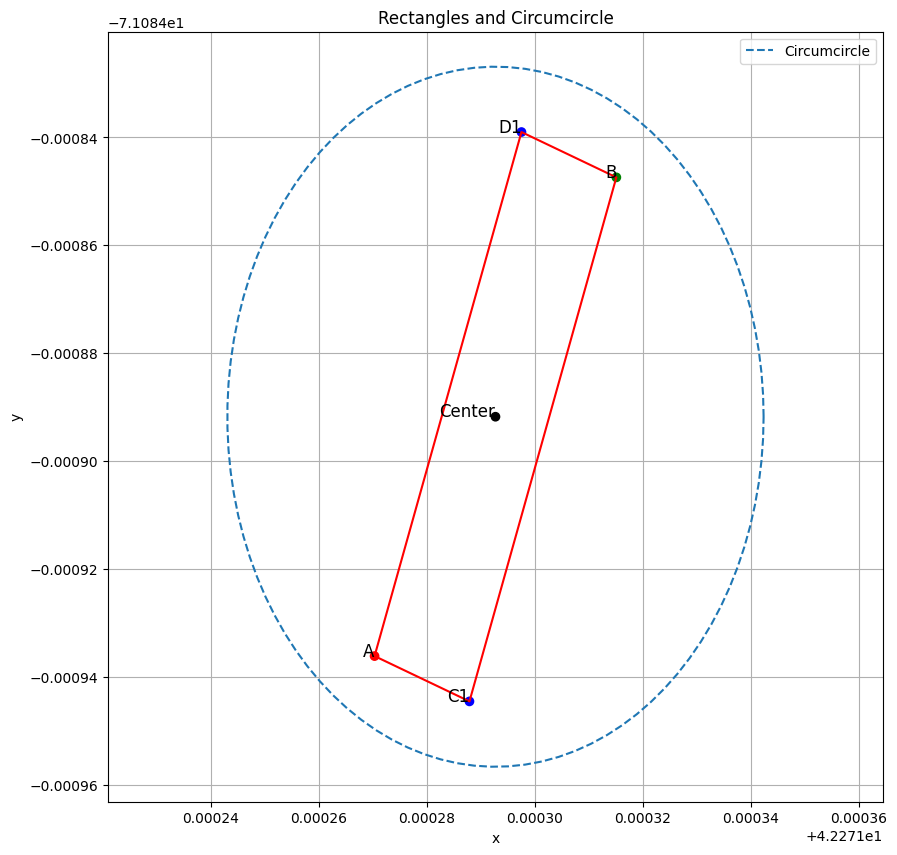

In [77]:
A, B, C1, D1 = df_results.iloc[7][['A', 'B', 'C', 'D']]
print (A , B , C1 , D1 )
lat1, lon1 = A
lat2, lon2 = B
lat_center = (lat1 + lat2) / 2
lon_center = (lon1 + lon2) / 2
center = (lat_center, lon_center)
d = sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)*METERS_PER_DEGREE_LAT
r = d / 2

# Convert the radius from meters to degrees
r_lat = r / METERS_PER_DEGREE_LAT
r_lon = r / METERS_PER_DEGREE_LON

# Data for the circumcircle
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = lat_center + r_lat * np.cos(theta)  # Latitude values
y_circle = lon_center + r_lon * np.sin(theta)  # Longitude values

# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_circle, y_circle, linestyle='--', label='Circumcircle')
plt.scatter(*zip(*[A, B, C1, D1, center]), c=['red', 'green', 'blue', 'blue', 'black'])


# Label points
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C1[0], C1[1], 'C1', fontsize=12, ha='right')
plt.text(D1[0], D1[1], 'D1', fontsize=12, ha='right')
plt.text(center[0], center[1], 'Center', fontsize=12, ha='right')
# Draw rectangles
rectangle1 = np.array([A, C1, B, D1, A])
plt.plot(rectangle1[:,0], rectangle1[:,1], 'r-')

plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rectangles and Circumcircle')
plt.grid(True)
plt.legend()
plt.show()

In [58]:
import folium

# Define coordinates for the points
points =  results[1]
# Calculate center of the map
lat_center = sum(p[0] for p in points) / len(points)
lon_center = sum(p[1] for p in points) / len(points)

# Create a map centered around the points
m = folium.Map(location=[lat_center, lon_center], zoom_start=18)

# Add points to the map
for point in points:
    folium.Circle(point, radius=1, color='red').add_to(m)

# Display the map
m

In [5]:
import math

# Average latitude for North America (example: 40 degrees North)
average_latitude = 40

# Constants for distance calculations
METERS_PER_DEGREE_LAT = 111000  # Approximate meters per degree of latitude
METERS_PER_DEGREE_LON = METERS_PER_DEGREE_LAT * math.cos(math.radians(average_latitude))
print(METERS_PER_DEGREE_LON)


85030.93318620656


In [27]:
import sympy as sp

import math

def haversine_distance(lat1, lon1, lat2, lon2):

    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers is approximately 6,371 km
    r = 6371e3  # in meters
    return c * r

def diagonal_distance(ax, ay, bx, by):
    return sp.sqrt((ax - bx)**2 + (ay - by)**2)

def find_rectangle_sides(area, diagonal):
    w, h = sp.symbols('w h')
    equations = (w * h - area, w**2 + h**2 - diagonal**2)
    solutions = sp.solve(equations, (w, h))
    
    # Check if solutions is a list of tuples (indicating multiple solutions)
    if isinstance(solutions, list) and all(isinstance(sol, tuple) for sol in solutions):
        return [(abs(sol[0]), abs(sol[1])) for sol in solutions if sol[0].is_real and sol[1].is_real]
    # Check if solutions is a single tuple (indicating a single solution)
    elif isinstance(solutions, tuple):
        return [(abs(solutions[0]), abs(solutions[1]))] if solutions[0].is_real and solutions[1].is_real else []
    # If solutions is not a list or tuple, it's an unexpected return type
    else:
        return []

def find_rectangle_points(ax, ay, bx, by, area):
    d = diagonal_distance(ax, ay, bx, by)
    w_h_pairs = find_rectangle_sides(area, d)
    if not w_h_pairs:
        return None, None
    w, h = w_h_pairs[0]
    cx, cy = ax + w, ay
    dx, dy = cx, cy + h
    return (cx, cy), (dx, dy)

# Function to process each sample box in the data
def process_sample_boxes(roofSegmentStats_data):
    for i, sample in enumerate(roofSegmentStats_data):
        sw_lat = sample['boundingBox']['sw']['latitude']
        sw_long = sample['boundingBox']['sw']['longitude']
        ne_lat = sample['boundingBox']['ne']['latitude']
        ne_long = sample['boundingBox']['ne']['longitude']

        # Calculate the diagonal distance
        d = diagonal_distance(sw_lat, sw_long, ne_lat, ne_long)
        # change d to meters
        def convert_to_meters(d):
            return d * 111000
        print (f"Sample {i+1}: d = {d}")

        # Get the area from the sample data
        area = sample['stats']['areaMeters2']
        print(f"Sample {i+1}: area = {area}")
        
        # Calculate points C and D for the rectangle
        C, D = find_rectangle_points(sw_lat, sw_long, ne_lat, ne_long, area)
        
        # Store the results in the sample data
        sample['boundingBox']['alternativeBox'] = {'C': C, 'D': D}

        # Output the results
        print(f"Sample {i+1}: SW = ({sw_lat}, {sw_long}), NE = ({ne_lat}, {ne_long}), C = {C}, D = {D}")

# Call the function with your actual roofSegmentStats_data from the JSON file
process_sample_boxes(roofSegmentStats_data)


Sample 1: d = 0.000115381324312536
Sample 1: area = 25.707256
Sample 1: SW = (42.271187999999995, -71.0849068), NE = (42.271236699999996, -71.0848022), C = None, D = None
Sample 2: d = 0.0000911737352579643
Sample 2: area = 22.291653
Sample 2: SW = (42.271228099999995, -71.0849289), NE = (42.2712808, -71.08485449999999), C = None, D = None
Sample 3: d = 0.0000851711805863390
Sample 3: area = 20.261522
Sample 3: SW = (42.271233699999996, -71.08487250000002), NE = (42.2712994, -71.0848183), C = None, D = None
Sample 4: d = 0.0000993716760369290
Sample 4: area = 19.979897
Sample 4: SW = (42.2712703, -71.0849361), NE = (42.271315099999995, -71.0848474), C = None, D = None
Sample 5: d = 0.000112485110127748
Sample 5: area = 10.486612
Sample 5: SW = (42.2711889, -71.084957), NE = (42.2712888, -71.0849053), C = None, D = None
Sample 6: d = 0.0000575146068388128
Sample 6: area = 7.98301
Sample 6: SW = (42.2712104, -71.08491529999999), NE = (42.2712356, -71.08486359999999), C = None, D = None


In [45]:
import sympy as sp

def find_rectangle_sides(area, diagonal):
    # Define symbols for width (w) and height (h)
    w, h = sp.symbols('w h', real=True)

    # Set up the system of equations based on the area and the length of the diagonal
    equations = (w * h - area, w**2 + h**2 - diagonal**2)

    # Solve the system of equations
    solutions = sp.solve(equations, (w, h))

    # Filter the solutions to find the pair where w and h are real and positive
    real_solutions = []
    for sol in solutions:
        if isinstance(sol, tuple) and all(val.is_real and val > 0 for val in sol):
            real_solutions.append((abs(sol[0]), abs(sol[1])))

    # Ensure that the solutions indeed form a rectangle by checking the dot product
    # In this context, since the sides are aligned with the coordinate axes, one side would be a vector along the x-axis and the other along the y-axis
    # Hence, their dot product is inherently zero, and we don't need an explicit check here.

    return real_solutions



# Function to calculate points C and D in UTM
def find_rectangle_points_utm(ax, ay, bx, by, area):
    # Convert to UTM coordinates
    ax, ay = latlon_to_utm(ax, ay)
    bx, by = latlon_to_utm(bx, by)

    # Calculate the diagonal distance in UTM
    diagonal = ((bx - ax) ** 2 + (by - ay) ** 2) ** 0.5

    # Use the function to find the sides of the rectangle
    w_h_pairs = find_rectangle_sides(area, diagonal)
    
    # If there's no valid solution, return None
    if not w_h_pairs:
        return None, None
    
    # We choose the first pair of sides as a valid solution (width, height)
    w, h = w_h_pairs[0]

    # Calculate points C and D in UTM
    # Assuming the width is along the x-axis
    cx, cy = ax + w, ay
    dx, dy = ax, ay + h

    return (cx, cy), (dx, dy)

# Function to process each sample box in the data
def process_sample_boxes(roofSegmentStats_data):
    for i, sample in enumerate(roofSegmentStats_data):
        # Extract latitude and longitude from the sample
        sw_lat = sample['boundingBox']['sw']['latitude']
        sw_long = sample['boundingBox']['sw']['longitude']
        ne_lat = sample['boundingBox']['ne']['latitude']
        ne_long = sample['boundingBox']['ne']['longitude']

        # Get the area from the sample data
        area = sample['stats']['areaMeters2']
        
        # Calculate points C and D for the rectangle in UTM
        C_utm, D_utm = find_rectangle_points_utm(sw_lat, sw_long, ne_lat, ne_long, area)

        # Only proceed if a valid solution was found
        if C_utm and D_utm:
            # Convert C and D back to latitude and longitude
            C_lat, C_lon = utm_projection(C_utm[0], C_utm[1], inverse=True)
            D_lat, D_lon = utm_projection(D_utm[0], D_utm[1], inverse=True)

            # Store the results in the sample data
            sample['boundingBox']['alternativeBox'] = {
                'C': {'latitude': C_lat, 'longitude': C_lon},
                'D': {'latitude': D_lat, 'longitude': D_lon}
            }

            # Output the results
            print(f"Sample {i+1}: SW = ({sw_lat}, {sw_long}), NE = ({ne_lat}, {ne_long}), C = ({C_lat}, {C_lon}), D = ({D_lat}, {D_lon})")
        else:
            print(f"Sample {i+1}: No valid rectangle can be formed with the given area and diagonal distance.")

process_sample_boxes(roofSegmentStats_data)


Sample 1: SW = (42.271187999999995, -71.0849068), NE = (42.271236699999996, -71.0848022), C = (-71.08480711982187, 42.27113651130026), D = (-71.08489405206389, 42.27120161332616)
Sample 2: SW = (42.271228099999995, -71.0849289), NE = (42.2712808, -71.08485449999999), C = (-71.08484672620763, 42.271185654071246), D = (-71.08491549079878, 42.27124241947167)
Sample 3: SW = (42.271233699999996, -71.08487250000002), NE = (42.2712994, -71.0848183), C = (-71.08478909733158, 42.27119061922276), D = (-71.08486049157206, 42.27124652358111)
Sample 4: SW = (42.2712703, -71.0849361), NE = (42.271315099999995, -71.0848474), C = (-71.08484958007159, 42.27122560912674), D = (-71.08492468510437, 42.271282489770506)
Sample 5: SW = (42.2711889, -71.084957), NE = (42.2712888, -71.0849053), C = (-71.08483886458247, 42.271127878537555), D = (-71.08495261218931, 42.271193585685474)
Sample 6: SW = (42.2712104, -71.08491529999999), NE = (42.2712356, -71.08486359999999), C = (-71.08486584479459, 42.271184854484

In [47]:
import pandas as pd
import sympy as sp
import utm

def find_rectangle_sides(area, diagonal):
    # Define symbols for width (w) and height (h)
    w, h = sp.symbols('w h', real=True)
    # Set up the system of equations based on the area and the length of the diagonal
    equations = (w * h - area, w**2 + h**2 - diagonal**2)
    # Solve the system of equations
    solutions = sp.solve(equations, (w, h))
    # Filter the solutions to find the pair where w and h are real and positive
    real_solutions = [(abs(sp.re(w_val)), abs(sp.re(h_val))) for w_val, h_val in solutions if sp.re(w_val).is_real and sp.re(h_val).is_real]
    return real_solutions

def find_rectangle_points_utm(ax, ay, bx, by, area):
    # Convert to UTM coordinates
    ax, ay, _, _ = utm.from_latlon(ax, ay)
    bx, by, _, _ = utm.from_latlon(bx, by)
    # Calculate the diagonal distance in UTM
    diagonal = ((bx - ax)**2 + (by - ay)**2)**0.5
    # Use the function to find the sides of the rectangle
    w_h_pairs = find_rectangle_sides(area, diagonal)
    # If there's no valid solution, return None
    if not w_h_pairs:
        return None, None
    # We choose the first pair of sides as a valid solution (width, height)
    w, h = w_h_pairs[0]
    # Calculate points C and D in UTM
    cx, cy = ax + w, ay
    dx, dy = ax, ay + h
    return (cx, cy), (dx, dy)

def process_sample_boxes(roofSegmentStats_data):
    data_for_df = []
    for i, sample in enumerate(roofSegmentStats_data):
        sw_lat = sample['boundingBox']['sw']['latitude']
        sw_long = sample['boundingBox']['sw']['longitude']
        ne_lat = sample['boundingBox']['ne']['latitude']
        ne_long = sample['boundingBox']['ne']['longitude']
        area = sample['stats']['areaMeters2']
        C_utm, D_utm = find_rectangle_points_utm(sw_lat, sw_long, ne_lat, ne_long, area)
        if C_utm and D_utm:
            C_lat, C_lon = utm.to_latlon(C_utm[0], C_utm[1], utm.latlon_to_zone_number(sw_lat, sw_long))
            D_lat, D_lon = utm.to_latlon(D_utm[0], D_utm[1], utm.latlon_to_zone_number(sw_lat, sw_long))
            data_for_df.append({
                'Sample': i + 1,
                'SW_lat': sw_lat,
                'SW_long': sw_long,
                'NE_lat': ne_lat,
                'NE_long': ne_long,
                'C_lat': C_lat,
                'C_long': C_lon,
                'D_lat': D_lat,
                'D_long': D_lon,
                'Area': area,
                'Valid_Rectangle': True
            })
        else:
            data_for_df.append({
                'Sample': i + 1,
                'SW_lat': sw_lat,
                'SW_long': sw_long,
                'NE_lat': ne_lat,
                'NE_long': ne_long,
                'C_lat': None,
                'C_long': None,
                'D_lat': None,
                'D_long': None,
                'Area': area,
                'Valid_Rectangle': False
            })
    return pd.DataFrame(data_for_df)

# Assuming roofSegmentStats_data is provided and contains the necessary information
# Replace with the actual data
# roofSegmentStats_data = [...] 

# Uncomment the following line and replace with the actual data
df_results = process_sample_boxes(roofSegmentStats_data)
df_results.head()  # Display the first few rows of the DataFrame


ValueError: either zone_letter or northern needs to be set

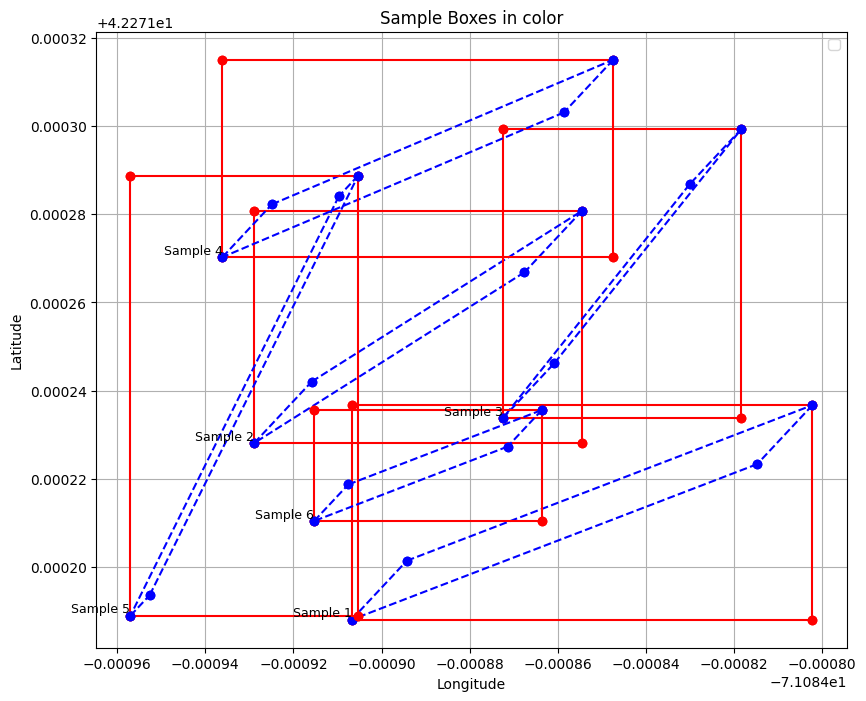

In [36]:
import matplotlib.pyplot as plt



# Function to plot a sample
def plot_sample(sample, ax, label):
    # Extract points
    SW = sample['SW'][::-1]  # Reverse to (longitude, latitude)
    NE = sample['NE'][::-1]
    C = sample['C']
    D = sample['D']
    
    # Calculate the NW and SE points to complete the rectangle
    NW = (SW[0], NE[1])
    SE = (NE[0], SW[1])
    
    # Draw the original box (SW, NW, NE, SE)
    ax.plot([SW[0], NW[0]], [SW[1], NW[1]], 'ro-')  # West line
    ax.plot([NW[0], NE[0]], [NW[1], NE[1]], 'ro-')  # North line
    ax.plot([NE[0], SE[0]], [NE[1], SE[1]], 'ro-')  # East line
    ax.plot([SE[0], SW[0]], [SE[1], SW[1]], 'ro-')  # South line
    
    # Draw the alternative box (SW, C, NE, D)
    ax.plot([SW[0], C[0]], [SW[1], C[1]], 'bo--')  # South line
    ax.plot([C[0], NE[0]], [C[1], NE[1]], 'bo--')  # East line
    ax.plot([NE[0], D[0]], [NE[1], D[1]], 'bo--')  # North line
    ax.plot([D[0], SW[0]], [D[1], SW[1]], 'bo--')  # West line
    
    # Label the sample
    ax.text(SW[0], SW[1], label, fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Sample Boxes in color') 

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
ax.grid(True)
ax.legend(['Original', 'Alternative'])

# Plot each sample with a unique label
for i, sample in enumerate(samples):
    plot_sample(sample, ax, f'Sample {i+1}')

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Show the plot with a grid
ax.grid(True)
plt.show()


In [17]:
if roofSegmentStats_data:
    # Print the structure of the first bounding box
    first_sample = roofSegmentStats_data[0]
    first_bounding_box = first_sample.get('boundingBox', None)
    if first_bounding_box:
        print(f"First bounding box structure: {first_bounding_box}")
        print(f"SW Latitude: {first_bounding_box['sw']['latitude']}")
        print(f"SW Longitude: {first_bounding_box['sw']['longitude']}")
        print(f"NE Latitude: {first_bounding_box['ne']['latitude']}")
        print(f"NE Longitude: {first_bounding_box['ne']['longitude']}")
    else:
        print("First sample does not contain a 'boundingBox'.")
else:
    print("No data in 'roofSegmentStats'.")




First bounding box structure: {'sw': {'latitude': 32.750347, 'longitude': -117.16028879999999}, 'ne': {'latitude': 32.750606399999995, 'longitude': -117.15983460000001}, 'alternativeBox1': {'C': (25208743988795.5 - 64401116725.7851*I, 64401116608.625 + 25208743988762.8*I)}, 'alternativeBox2': {'C': (25208743988795.5 + 64401116725.7851*I, 64401116608.625 - 25208743988762.8*I)}}
SW Latitude: 32.750347
SW Longitude: -117.16028879999999
NE Latitude: 32.750606399999995
NE Longitude: -117.15983460000001


(0, 0) (4, 3) (0.0, 3.00000000000000) (2.88000000000000, -0.840000000000000) (4.00000000000000, 0) (1.12000000000000, 3.84000000000000)


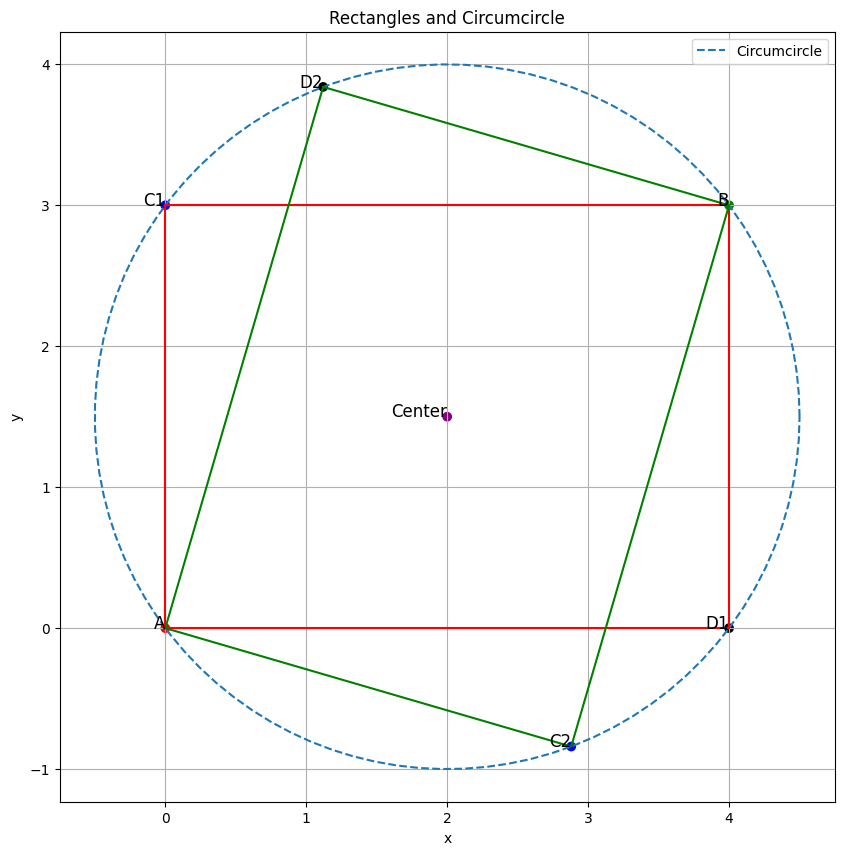

In [4]:
print (A , B , C1 , C2 , D1 , D2)
center = (x_center, y_center)

# Data for the circumcircle
theta = np.linspace(0, 2*np.pi, 100)
x_circle = center[0] + r * np.cos(theta)
y_circle = center[1] + r * np.sin(theta)


# Plotting
plt.figure(figsize=(10, 10))
plt.plot(x_circle, y_circle, linestyle='--', label='Circumcircle')
plt.scatter(*zip(*[A, B, C1, C2, center,D1,D2]), c=['red', 'green', 'blue', 'blue', 'purple','black','black'])


# Label points
plt.text(A[0], A[1], 'A', fontsize=12, ha='right')
plt.text(B[0], B[1], 'B', fontsize=12, ha='right')
plt.text(C1[0], C1[1], 'C1', fontsize=12, ha='right')
plt.text(C2[0], C2[1], 'C2', fontsize=12, ha='right')
plt.text(D1[0], D1[1], 'D1', fontsize=12, ha='right')
plt.text(D2[0], D2[1], 'D2', fontsize=12, ha='right')
plt.text(center[0], center[1], 'Center', fontsize=12, ha='right')

# Draw rectangles
rectangle1 = np.array([A, C1, B, D1, A])
rectangle2 = np.array([A, C2, B, D2, A])
plt.plot(rectangle1[:,0], rectangle1[:,1], 'r-')
plt.plot(rectangle2[:,0], rectangle2[:,1], 'g-')

plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rectangles and Circumcircle')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
from sympy import symbols, Eq, solve, sqrt

# Function to calculate the distance between two points
def calculate_distance(x1, y1, x2, y2):
    # Calculate the distance using Pythagorean theorem
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Function to find points C and D given two diagonal points of a rectangle and its area
def find_points_C_and_D(sw_lat, sw_long, ne_lat, ne_long, area):
    # Define symbolic variables for C's coordinates
    x3, y3 = symbols('x3 y3')

    # Midpoint coordinates (center of the rectangle)
    x_center = (sw_lat + ne_lat) / 2
    y_center = (sw_long + ne_long) / 2

    # Distance between the known SW and NE points
    diagonal = calculate_distance(sw_lat, sw_long, ne_lat, ne_long)
    r = diagonal / 2  # Radius of the circumcircle

    # Other dimension (width or height) using the area and the diagonal
    other_dimension = area / diagonal

    # Equations to solve
    eq1 = Eq((x3 - x_center)**2 + (y3 - y_center)**2, r**2)
    eq2 = Eq(sqrt((x3 - sw_lat)**2 + (y3 - sw_long)**2), other_dimension)
    eq3 = Eq((x3 - sw_lat) * (ne_lat - x3) + (y3 - sw_long) * (ne_long - y3), 0)

    # Solving the equations
    solutions = solve((eq1, eq2, eq3), (x3, y3))

    # If no solution is found, return None
    if not solutions:
        return None, None, None, None

    # Extract solutions for C1 and C2
    C1, C2 = solutions

    # Calculate corresponding D points by reflecting C points over the midpoint
    D1 = (2 * x_center - C1[0], 2 * y_center - C1[1])
    D2 = (2 * x_center - C2[0], 2 * y_center - C2[1])

    # Return the coordinates of C and D
    return C1, D1, C2, D2

# Sample data (structure based on the user's JSON structure)
roofSegmentStats_data = [
    {'stats': {'areaMeters2': 80.44886},
     'boundingBox': {'sw': {'latitude': 42.2541204, 'longitude': -70.96283369999999},
                     'ne': {'latitude': 42.2542924, 'longitude': -70.9627678}}},
    # ... (other samples would be listed here)
]

# Test the function with the provided data
for sample in roofSegmentStats_data:
    sw_lat = sample['boundingBox']['sw']['latitude']
    sw_long = sample['boundingBox']['sw']['longitude']
    ne_lat = sample['boundingBox']['ne']['latitude']
    ne_long = sample['boundingBox']['ne']['longitude']
    area = sample['stats']['areaMeters2']

    # Find points C and D for the rectangle
    C1, D1, C2, D2 = find_points_C_and_D(sw_lat, sw_long, ne_lat, ne_long, area)

    # If solutions are found, store the alternative boxes
    if C1 and D1 and C2 and D2:
        sample['boundingBox']['alternativeBox1'] = {'C': C1, 'D': D1}
        sample['boundingBox']['alternativeBox2'] = {'C': C2, 'D': D2}
    else:
        print(f"No solutions found for sample with SW: ({sw_lat}, {sw_long}) and NE: ({ne_lat}, {ne_long})")

roofSegmentStats_data  # This should now include the alternative boxes for each sample



ValueError: not enough values to unpack (expected 2, got 0)